In [1]:
from random import randrange

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
class CustomModel(nn.Module):

    def __init__(self, f1):
        super().__init__()
        self.f1 = f1
        self.conv1 = self.conv_block(f1.input_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, f1.num_classes),
        )

    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = self.f1.accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )

In [3]:
class DeviceDataLoader:
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1

    def __iter__(self):
        for b in self.dl:
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [4]:
class CNN:
    def __init__(self):
        print("constructor")

    def init_hyp(self):
        self.batch_size = 128
        self.lr = 0.001
        self.epoch = 20
        self.max_lr = 0.01
        self.grad_clip = 0.1
        self.weight_decay = 1e-4

    def get_data(self):
        #         self.Dataset = MNIST
        #         self.Dataset = FashionMNIST
        self.Dataset = CIFAR10

        self.dataset = self.Dataset(
            root="data/", train=True, transform=transforms.ToTensor(), download=True
        )
        self.input_size = np.prod(self.dataset[0][0].shape)
        self.input_channels = self.dataset[0][0].shape[0]
        self.num_classes = len(self.dataset.classes)

    def init_data(self):
        self.get_data()
        self.init_hyp()
        self.model = CustomModel(self)
        self.device = self.get_default_device()
        self.to_device(self.model, self.device)

        train_ds, val_ds = random_split(
            self.dataset, [int(len(self.dataset) * 0.8), int(len(self.dataset) * 0.2)]
        )
        self.test_ds = self.Dataset(
            root="data/", train=False, transform=transforms.ToTensor()
        )

        self.train_loader_cpu = DataLoader(train_ds, self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ds, self.batch_size * 2)
        self.test_loader = DataLoader(self.test_ds, self.batch_size * 2)

        self.train_loader = DeviceDataLoader(self, self.train_loader_cpu, self.device)
        self.val_loader = DeviceDataLoader(self, self.val_loader, self.device)
        self.test_loader = DeviceDataLoader(self, self.test_loader, self.device)

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    @torch.no_grad()
    def evaluate(self, data):
        self.model.eval()
        outputs = [self.model.validation_step(batch) for batch in data]
        return self.model.validation_epoch_end(outputs)

    def display_batch(self):
        for images, _ in self.train_loader_cpu:
            print("images.shape:", images.shape)
            plt.figure(figsize=(16, 8))
            plt.axis("off")
            plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
            break

    def fit(self, opt_func=torch.optim.Adam):
        torch.cuda.empty_cache()
        self.history = []
        optimizer = opt_func(self.model.parameters(), self.lr)

        optimizer = opt_func(
            self.model.parameters(), self.max_lr, weight_decay=self.weight_decay
        )
        sched = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.max_lr,
            epochs=self.epoch,
            steps_per_epoch=len(self.train_loader),
        )
        for e in range(self.epoch):
            self.model.train()
            train_losses = []
            lrs = []
            for batch in self.train_loader:
                loss = self.model.training_step(batch)
                train_losses.append(loss)
                loss.backward()

                if self.grad_clip:
                    nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)

                optimizer.step()
                optimizer.zero_grad()

                lrs.append(self.get_lr(optimizer))
                sched.step()

            # Validation phase
            result = self.evaluate(self.val_loader)
            result["train_loss"] = torch.stack(train_losses).mean().item()
            result["lrs"] = lrs
            self.model.epoch_end(e, result)
            self.history.append(result)

    def plot_acc(self):
        accuracies = [r["val_acc"] for r in self.history]
        plt.plot(accuracies, "-x")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title("Accuracy vs. No. of epochs")

    def plot_loss(self):
        losses = [r["val_loss"] for r in self.history]
        plt.plot(losses, "-x")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss vs. No. of epochs")

    def predict_rand_image(self):
        img_i = randrange(0, len(self.test_ds), 1)
        img, label = self.test_ds[img_i]
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        print(
            "Label:",
            self.test_ds.classes[label],
            ", Predicted:",
            self.test_ds.classes[self.predict_image(img)],
        )

    def predict_image(self, img):
        xb = self.to_device(img.unsqueeze(0), self.device)
        yb = self.model(xb)
        _, preds = torch.max(yb, dim=1)
        return preds[0].item()

    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device("cuda")
        else:
            return torch.device("cpu")

    def to_device(self, data, device):
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)

    def get_lr(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group["lr"]

In [5]:
f1 = CNN()

constructor


In [6]:
f1.init_data()

Files already downloaded and verified


In [7]:
f1.get_default_device()

device(type='cpu')

images.shape: torch.Size([128, 3, 32, 32])


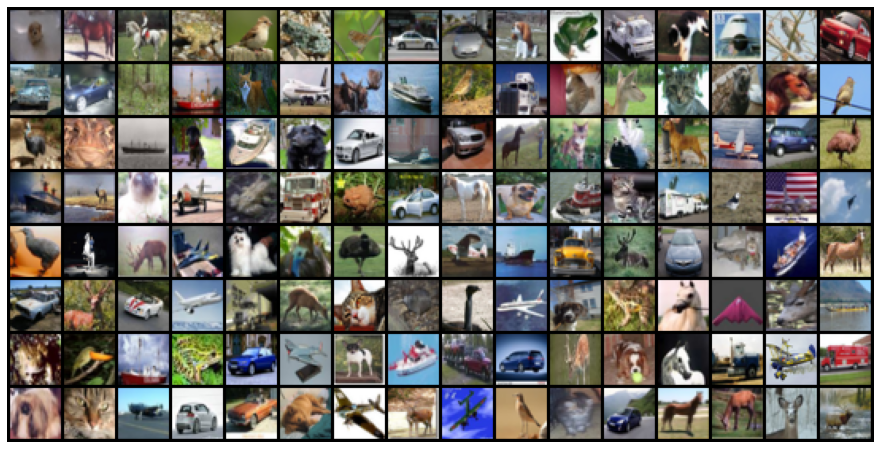

In [8]:
f1.display_batch()

In [9]:
f1.evaluate(f1.test_loader)

{'val_loss': 2.3036580085754395, 'val_acc': 0.09912109375}

In [65]:
f1.fit()

Epoch [0], val_loss: 1.0369, val_acc: 0.6327
Epoch [1], val_loss: 1.2188, val_acc: 0.5817
Epoch [2], val_loss: 1.9842, val_acc: 0.4673
Epoch [3], val_loss: 1.0359, val_acc: 0.6689
Epoch [4], val_loss: 1.0822, val_acc: 0.6680
Epoch [5], val_loss: 0.8191, val_acc: 0.7419
Epoch [6], val_loss: 0.8460, val_acc: 0.7136
Epoch [7], val_loss: 1.0357, val_acc: 0.6239
Epoch [8], val_loss: 0.7356, val_acc: 0.7520
Epoch [9], val_loss: 0.8126, val_acc: 0.7294
Epoch [10], val_loss: 0.5946, val_acc: 0.8084
Epoch [11], val_loss: 0.6388, val_acc: 0.7911
Epoch [12], val_loss: 0.7488, val_acc: 0.7542
Epoch [13], val_loss: 0.5598, val_acc: 0.8212
Epoch [14], val_loss: 0.5207, val_acc: 0.8391
Epoch [15], val_loss: 0.5087, val_acc: 0.8556
Epoch [16], val_loss: 0.4344, val_acc: 0.8837
Epoch [17], val_loss: 0.4262, val_acc: 0.8919
Epoch [18], val_loss: 0.4259, val_acc: 0.8952
Epoch [19], val_loss: 0.4276, val_acc: 0.8953


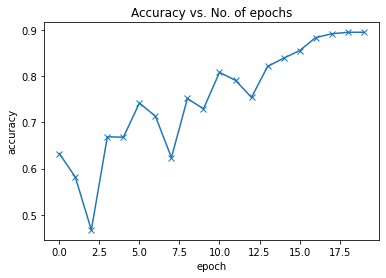

In [66]:
f1.plot_acc()

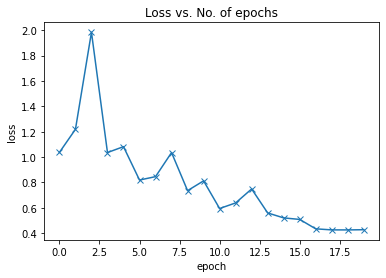

In [67]:
f1.plot_loss()

In [68]:
f1.evaluate(f1.test_loader)

{'val_loss': 0.4326164424419403, 'val_acc': 0.8866211175918579}

torch.Size([3, 32, 32])
Label: horse , Predicted: cat


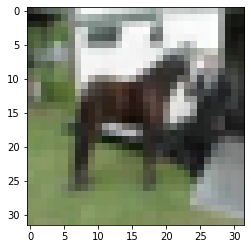

In [81]:
f1.predict_rand_image()